### This script shows how the tag frequency mapping has been done and how the tagcloud has been generated both for the whole dataset as used in the RS Experiment, but also on a user profile basis 

In [1]:
# Loading dependencies
import argparse
import codecs
import logging
import time
import tqdm
import h5py
from scipy.sparse import coo_matrix, csr_matrix
import scipy.sparse as sp
from random import randint
import pickle

#### wordcloud dependencies
import matplotlib.pyplot as plt # data visualization library
from wordcloud import WordCloud, STOPWORDS #used to generate world cloud
import seaborn as sns

import itertools
import numpy as np
import pandas as pd

# Loading data

In [2]:
# borrowed from https://github.com/benfred/implicit, modified to read the file locally instead of downloading it.
def get_lastfm():
    """Returns a tuple of (artistids, userids, plays) where plays is a CSR matrix """
    
    filename = '../flaskapp/data/lastfm_360k.hdf5'

    with h5py.File(filename, 'r') as f:
        m = f.get('artist_user_plays')
        plays = csr_matrix((m.get('data'), m.get('indices'), m.get('indptr')))
        return np.array(f['artist']), np.array(f['user']), plays

In [3]:
# loading data
artists, users, plays = get_lastfm()

# loading tags

In [5]:
# reading tags --> currently only sample file
tags_df = pd.read_csv("../my_data/lastfm_tags_cleaned.csv", sep=',')

In [6]:
tags_df.iloc[0][1]

'riot grrrl|punk|hard rock|female vocalists|rock|punk rock|riot grrl|indie|american|female fronted'

# merging tags on the original raw dataset
download the dataset here: http://ocelma.net/MusicRecommendationDataset/index.html

In [7]:
print('missing tags for '+str(len(artists)-tags_df.artist.nunique())+' artists')

missing tags for 51880 artists


In [12]:
data = pd.read_csv("../dataset_lastfm360k/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv",sep='\t',names=['userId','artistId','artist','plays'])

In [13]:
# merging tags on the complete dataset
df = data.merge(tags_df,on='artist', how='left')

# This (below cell) is tideous, takes ~23 minutes for the whole dataset.

In [ ]:
## creating a set of all the tags in the dataset
#start = time.time()
#tags = set()
#with tqdm.tqdm(total=len(tags_df['tags'])) as progress:
#    for s in tags_df['tags'].str.split('|').values:
#        try:
#            tags = tags.union(set(s))
#        except:
#            print("fail: " + str(s))
#            pass
#        progress.update(1)
#print(time.time()-start)

In [22]:
# pickle tag_labels set:
#pickling_on = open("../my_data/tag_set.pickle","wb")
#pickle.dump(tags, pickling_on)
#pickling_on.close()

In [21]:
pickle_off = open("../my_data/tag_set.pickle","rb")
tags = pickle.load(pickle_off)

In [22]:
# this many unique tags represented
len(tags)

149201

In [31]:
# source : https://www.kaggle.com/jneupane12/analysis-of-movielens-dataset-beginner-sanalysis

#creating a function that counts the number of times each tag appear:
def count_tags(df, ref_col, tags):
    tag_count = dict()
    for t in tags: tag_count[t] = 0
    for tag_list in df[ref_col].str.split('|'):
        if type(tag_list) == float and pd.isnull(tag_list): continue
        for s in tag_list: 
            if pd.notnull(s): tag_count[s] += 1
    # convert the dictionary in a list to sort the tags by frequency
    tag_occurences = []
    for k,v in tag_count.items():
        tag_occurences.append([k,v])
    tag_occurences.sort(key = lambda x:x[1], reverse = True)
    return tag_occurences, tag_count

In [32]:
#counting how many times each of tags occur:
start = time.time()
tag_occurences, dum = count_tags(tags_df, 'tags', tag_set)
print(time.time()-start)

2.516826868057251


In [34]:
tag_occurences[0:10]

[['rock', 38253],
 ['electronic', 36327],
 ['pop', 26732],
 ['indie', 23116],
 ['under 2000 listeners', 21472],
 ['female vocalists', 21404],
 ['alternative', 19697],
 ['folk', 18608],
 ['experimental', 15646],
 ['american', 15386]]

In [36]:
del tag_occurences[4] # deleting index 4 "under 2000 listeners"

In [38]:
tag_occurences[0:10]

[['rock', 38253],
 ['electronic', 36327],
 ['pop', 26732],
 ['indie', 23116],
 ['female vocalists', 21404],
 ['alternative', 19697],
 ['folk', 18608],
 ['experimental', 15646],
 ['american', 15386],
 ['metal', 15140]]

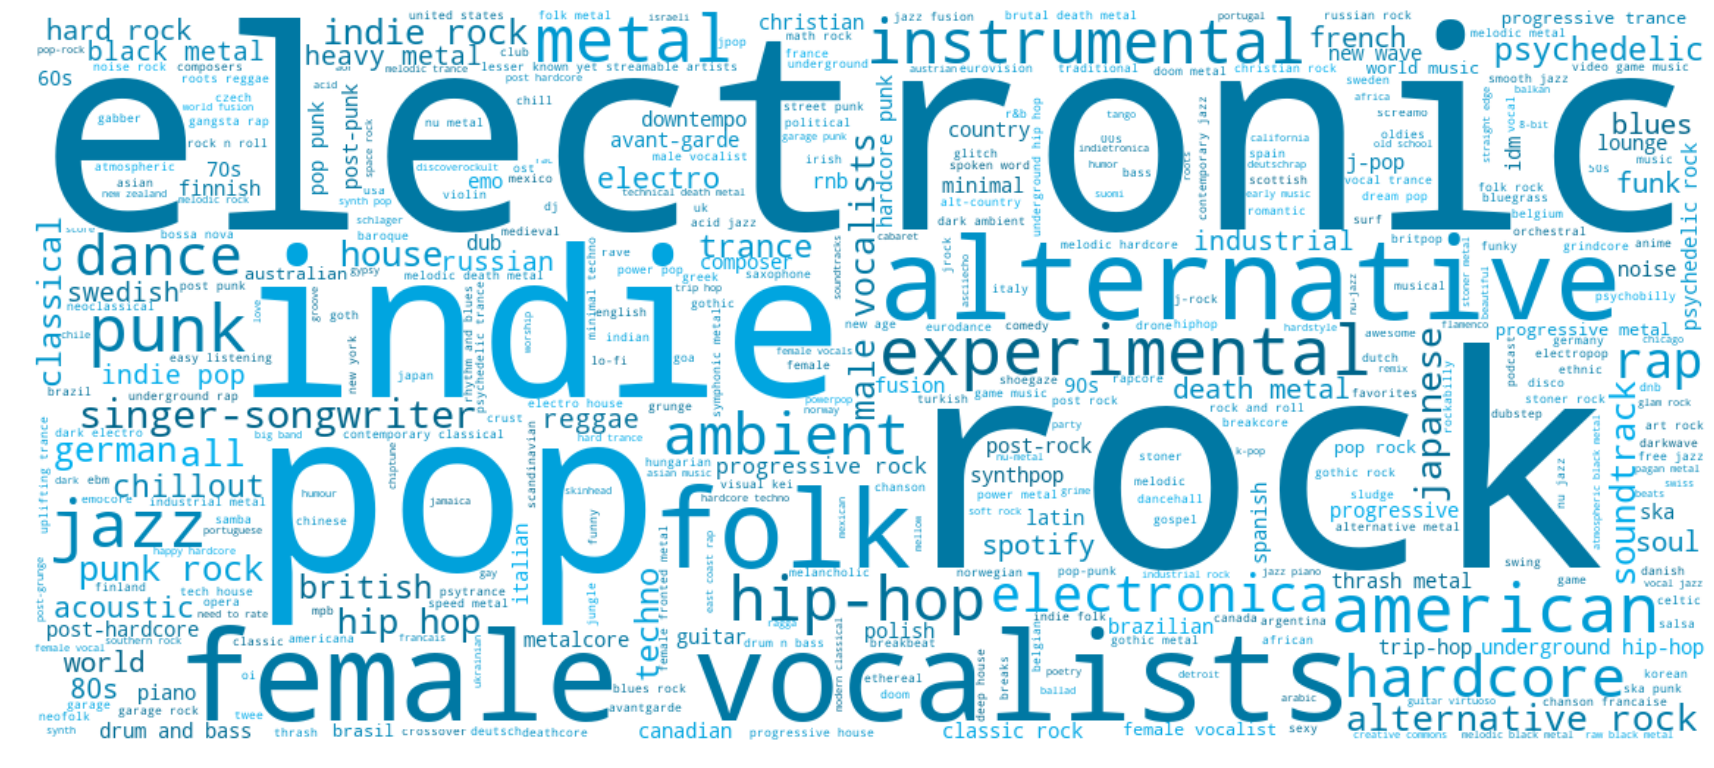

In [40]:
# source : https://www.kaggle.com/jneupane12/analysis-of-movielens-dataset-beginner-sanalysis

# set max words in cloud
max_w = 500

# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(100.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


#Finally, the result is shown as a wordcloud:
words = dict()
trunc_occurences = tag_occurences[0:400]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 500 # define the color of the words
f, ax = plt.subplots(figsize=(30, 20))
wordcloud = WordCloud(width=1140,height=500, background_color='white', 
                      # max words top 20 for limiting all the sub sub tags
                      max_words=max_w,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
# saving tagcloud
#plt.savefig('../my_data/wordcloud/tagcloud02_plus400.png',bbox_inches='tight')
plt.show()

# TODO / potential improvement:

### trim tag_occurences to only hold tags that are represented more than n times, e.g. 100 or 1000 times.

In [42]:
len(tag_occurences)

149200

In [45]:
# list comprehension --> https://www.python-course.eu/python3_list_comprehension.php
n = 200
print(len([(k,v) for k,v in tag_occurences if v > n]))
new_tag_occurences = [(k,v) for k,v in tag_occurences if v >n]

935


In [47]:
# this is the tail
new_tag_occurences[900:935]

[('latin rock', 212),
 ('demoscene', 212),
 ('psy trance', 212),
 ('elektro', 211),
 ('new rave', 211),
 ('harmonica blues', 211),
 ('darkcore', 211),
 ('prog rock', 210),
 ('ohio', 210),
 ('modern metal', 210),
 ('peru', 210),
 ('dsbm', 209),
 ('bard', 209),
 ('european', 209),
 ('iskelma', 208),
 ('mistagged', 207),
 ('singer', 207),
 ('italia', 206),
 ('nouvelle scene francaise', 206),
 ('jazz-funk', 206),
 ('favourite', 206),
 ('modern country', 205),
 ('crap', 205),
 ('alternative country', 205),
 ('piano jazz', 205),
 ('progressive metalcore', 204),
 ('krica morena', 204),
 ('michigan', 204),
 ('opm', 204),
 ('punjabi', 204),
 ('toronto', 203),
 ('crunk', 201),
 ('turkish folk', 201),
 ('guitarist', 201),
 ('hong kong', 201)]

---
# Tag cloud for a user profile example:
### Merging tags to user_profile

In [54]:
# returns a list (maybe do a dict artist/plays) of artist ids for a user
# TODO: add bool parameter and option to return dict of artist/plays
def get_profile(plays=csr_matrix, u_key=int):
    u = u_key
    cx = plays.tocoo()
    artist_count = plays.getcol(u_key).size
    arr = []
    cx = plays.getcol(u).tocoo()    
    for i,j,v in itertools.zip_longest(cx.row, cx.col, cx.data):
        #print(i,j,v)
        arr.append(i)
    print('number of artists in history: '+str(artist_count))
    df = pd.DataFrame(arr, columns=['artistKey'])
    #df = df['artistId'].merge(artists)
    return df, artist_count

In [28]:
u_key = 413

In [245]:
u_profile, u_artist_count = get_profile(plays,u_key)

number of artists in history: 49


In [274]:
#here we  make census of the tags:
user_tags = set()
for s in u_profile['tags'].str.split('|').values:
    user_tags = user_tags.union(set(s))

In [275]:
# mapping tags to user dataframe, it works.
u_profile = u_profile.merge(tags_df)
u_profile
lostArtists = u_artist_count-u_profile.artist.nunique()
print(str(lostArtists)+ ' artists are lost, because of missing tags')
print(str(u_profile.artist.nunique())+' artists left')

0 artists are lost, because of missing tags
49 artists left


In [278]:
#counting how many times each of tags occur:
tag_occurences, dum = count_tags(u_profile, 'tags', user_tags)

In [284]:
tag_occurences

In [280]:
result = []
for i in(tag_occurences):    
    i = str(i)
    i = i.replace('[','').replace(']','').replace('\'','')
    result.append(i)

# now visualize tag cloud

read the docs for visual enhancement: https://amueller.github.io/word_cloud/

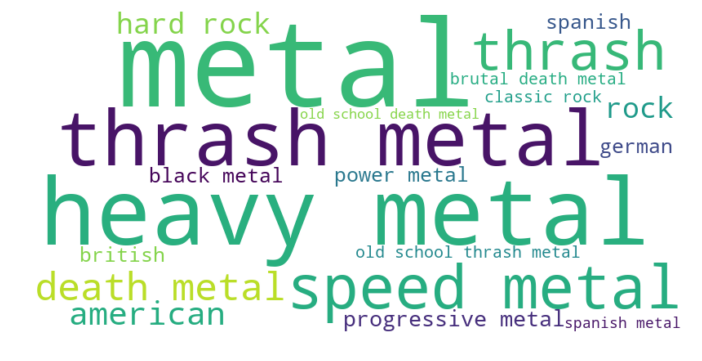

In [254]:
# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


#Finally, the result is shown as a wordcloud:
words = dict()
trunc_occurences = tag_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=800,height=400, background_color='white', 
                      # max words top 20 for limiting all the sub sub tags
                      max_words=20,relative_scaling=0.7,
                      #color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
# saving tagcloud
#plt.savefig('user '+str(u_key)+'_tagCloud.png',bbox_inches='tight')
plt.show()